In [1]:
# imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import trange

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

In [2]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
train_dir = 'dataset/Train'
test_dir = 'dataset/Test'

# prepare labels
all_classes = sorted(os.listdir(train_dir))
item_classes = sorted({cls.split('_')[1] for cls in all_classes})
fresh_classes = ['fresh', 'rotten']

item_to_index = {item: idx for idx, item in enumerate(item_classes)}
fresh_to_index = {'fresh': 1, 'rotten': 0}
index_to_item = {v: k for k, v in item_to_index.items()}
index_to_fresh = {v: k for k, v in fresh_to_index.items()}

In [3]:
# data generator
class MultiOutputDataGenerator(Sequence):
    def __init__(self, directory, item_to_index, fresh_to_index, batch_size=32, img_size=(150,150), shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)

        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment

        self.image_paths = []
        self.item_labels = []
        self.fresh_labels = []

        for class_dir in os.listdir(directory):
            class_path = os.path.join(directory, class_dir)
            if not os.path.isdir(class_path):
                continue
            freshness, item = class_dir.split('_')
            for fname in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, fname))
                self.item_labels.append(item_to_index[item])
                self.fresh_labels.append(fresh_to_index[freshness])

        self.on_epoch_end()

        self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=20 if augment else 0,
            zoom_range=0.2 if augment else 0,
            width_shift_range=0.1 if augment else 0,
            height_shift_range=0.1 if augment else 0,
            horizontal_flip=augment
        )
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        batch_images = []
        batch_items = []
        batch_freshness = []

        for i in batch_indices:
            img = load_img(self.image_paths[i], target_size=self.img_size)
            img = img_to_array(img)
            batch_images.append(img)

            item_onehot = tf.keras.utils.to_categorical(self.item_labels[i], num_classes=len(item_to_index))
            batch_items.append(item_onehot)
            batch_freshness.append([self.fresh_labels[i]])

        batch_images = np.array(batch_images) / 255.0
        batch_items = np.array(batch_items)
        batch_freshness = np.array(batch_freshness)

        return batch_images, {
            'item_output': batch_items,
            'fresh_output': batch_freshness
        }

In [4]:
# load datasets
train_data = MultiOutputDataGenerator(train_dir, item_to_index, fresh_to_index, batch_size=BATCH_SIZE, augment=True)
test_data = MultiOutputDataGenerator(test_dir, item_to_index, fresh_to_index, batch_size=BATCH_SIZE, shuffle=False)

# model
inputs = tf.keras.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# output
item_output = tf.keras.layers.Dense(len(item_to_index), activation='softmax', name='item_output')(x)
fresh_output = tf.keras.layers.Dense(1, activation='sigmoid', name='fresh_output')(x)

model = tf.keras.Model(inputs=inputs, outputs=[item_output, fresh_output])

model.compile(
    optimizer='adam',
    loss={
        'item_output': 'categorical_crossentropy',
        'fresh_output': 'binary_crossentropy'
    },
    metrics={
        'item_output': 'accuracy',
        'fresh_output': 'accuracy'
    }
)

In [5]:
# train model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

model.save("multioutput_food_model.keras")

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 419s 634ms/step - fresh_output_accuracy: 0.8438 - fresh_output_loss: 0.3222 - item_output_accuracy: 0.8585 - item_output_loss: 0.3719 - loss: 0.6941 - val_fresh_output_accuracy: 0.9107 - val_fresh_output_loss: 0.2078 - val_item_output_accuracy: 0.9187 - val_item_output_loss: 0.1902 - val_loss: 0.3979
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 516s 783ms/step - fresh_output_accuracy: 0.9295 - fresh_output_loss: 0.1669 - item_output_accuracy: 0.9486 - item_output_loss: 0.1285 - loss: 0.2953 - val_fresh_output_accuracy: 0.9374 - val_fresh_output_loss: 0.1579 - val_item_output_accuracy: 0.9561 - val_item_output_loss: 0.1196 - val_loss: 0.2774
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 358s 546ms/step - fresh_output_accuracy: 0.9539 - fresh_output_loss: 0.1143 - item_output_accuracy: 0.9648 - item_output_loss: 0.0871 - loss: 0.2014 - val_fresh_output_accuracy: 0.9534 - val_fresh_output_loss: 0.1167 - val_item_output_accuracy: 0.9695 - val_item_output_loss: 

210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step

Predictions done
Extracting true labels


extracting batches: 100%|██████████| 210/210 [00:18<00:00, 11.06it/s]


Label extraction complete

Item Classification Report:
              precision    recall  f1-score   support

       apple       1.00      0.99      1.00      1779
      banana       1.00      1.00      1.00      1792
    cucumber       0.98      1.00      0.99       534
        okra       1.00      0.98      0.99       594
      orange       0.99      0.99      0.99       791
      potato       1.00      1.00      1.00       640
      tomato       1.00      1.00      1.00       590

    accuracy                           1.00      6720
   macro avg       0.99      1.00      0.99      6720
weighted avg       1.00      1.00      1.00      6720


Freshness Classification Report:
              precision    recall  f1-score   support

      rotten       0.99      0.99      0.99      3475
       fresh       0.99      0.99      0.99      3245

    accuracy                           0.99      6720
   macro avg       0.99      0.99      0.99      6720
weighted avg       0.99      0.99      0.9

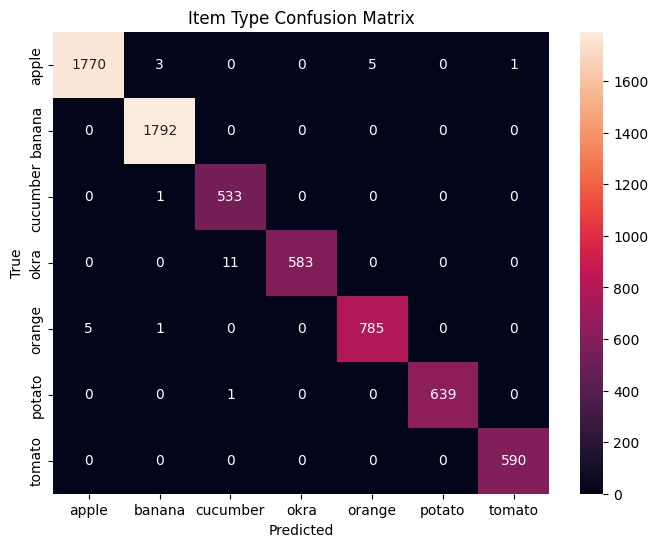

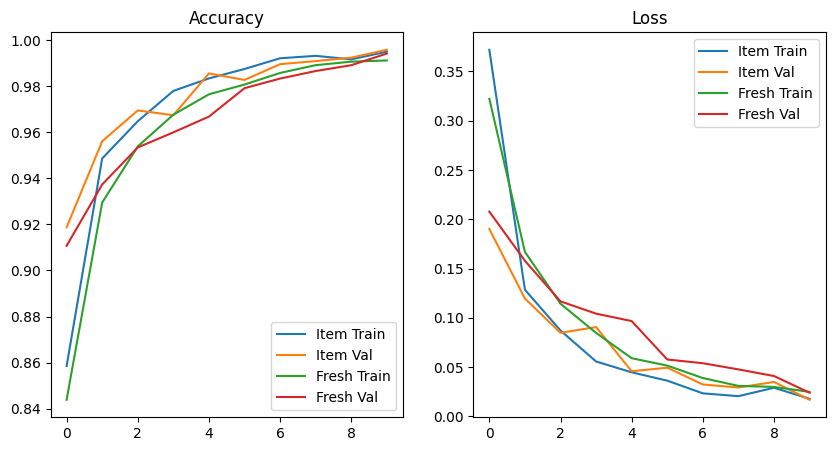

In [6]:
# run prediction over full test dataset
pred_items, pred_fresh = model.predict(test_data)
print("\nPredictions done")

# initialize label containers
y_true_items = []
y_true_fresh = []

# extract full true labels from test data
print("Extracting true labels")
for i in trange(len(test_data), desc="extracting batches"):
    _, labels = test_data[i]
    y_true_items.extend(np.argmax(labels['item_output'], axis=1))
    y_true_fresh.extend(labels['fresh_output'].flatten())
print("Label extraction complete")

# convert predictions to class labels
y_pred_items = np.argmax(pred_items, axis=1)
y_pred_fresh = (pred_fresh.flatten() > 0.5).astype(int)

# classification reports
print("\nItem Classification Report:")
print(classification_report(y_true_items, y_pred_items, target_names=item_classes))

print("\nFreshness Classification Report:")
print(classification_report(y_true_fresh, y_pred_fresh, target_names=['rotten', 'fresh']))

# confusion matrix for item prediction
cm = confusion_matrix(y_true_items, y_pred_items)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=item_classes, yticklabels=item_classes)
plt.title("Item Type Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['item_output_accuracy'], label='Item Train')
plt.plot(history.history['val_item_output_accuracy'], label='Item Val')
plt.plot(history.history['fresh_output_accuracy'], label='Fresh Train')
plt.plot(history.history['val_fresh_output_accuracy'], label='Fresh Val')
plt.legend()
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['item_output_loss'], label='Item Train')
plt.plot(history.history['val_item_output_loss'], label='Item Val')
plt.plot(history.history['fresh_output_loss'], label='Fresh Train')
plt.plot(history.history['val_fresh_output_loss'], label='Fresh Val')
plt.legend()
plt.title("Loss")

plt.show()

In [7]:
def predict_image_multioutput(model, img_path):
    img = load_img(img_path)
    img_array = img_to_array(img)

    img_array_resized = smart_resize(img_array, (150, 150)) / 255.0
    img_array_expanded = np.expand_dims(img_array_resized, axis=0)

    item_pred, fresh_pred = model.predict(img_array_expanded)
    item_idx = np.argmax(item_pred)
    fresh_val = "fresh" if fresh_pred[0][0] > 0.5 else "rotten"

    print(f"Item: {index_to_item[item_idx]} ({item_pred[0][item_idx]*100:.2f}%)")
    print(f"Freshness: {fresh_val} ({fresh_pred[0][0]*100:.2f}%)")

    plt.imshow(img_array_resized.astype("float32"))
    plt.title(f"{fresh_val} {index_to_item[item_idx]}")
    plt.axis('off')
    plt.show()